# Grapevine leaves classification, my own model part



    Reza Arabpour, 
    University of Tehran,
    Final version, Aug 2022.

## Environment Initialization

In [ ]:
#Loading General Tools and Libraries
import os
import random
import shutil
import sklearn
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from keras import layers
plt.style.use('ggplot')

## Data Loading

### Data Downloading

In [ ]:
#Loading Dataset
!rm -rf Grapevine_Leaves_Image_Dataset*
!rm -rf Test_Data
!wget https://www.muratkoklu.com/datasets/Grapevine_Leaves_Image_Dataset.zip
!unzip -q Grapevine_Leaves_Image_Dataset.zip 
!rm Grapevine_Leaves_Image_Dataset.zip
!ls -lh

--2022-08-06 06:26:31--  https://www.muratkoklu.com/datasets/Grapevine_Leaves_Image_Dataset.zip
Resolving www.muratkoklu.com (www.muratkoklu.com)... 185.179.25.150
Connecting to www.muratkoklu.com (www.muratkoklu.com)|185.179.25.150|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 113862245 (109M) [application/zip]
Saving to: ‘Grapevine_Leaves_Image_Dataset.zip’

Grapevine_Leaves_Im 100%[===================>] 108.59M  20.7MB/s    in 6.3s    

2022-08-06 06:26:38 (17.4 MB/s) - ‘Grapevine_Leaves_Image_Dataset.zip’ saved [113862245/113862245]

total 8.0K
drwxr-xr-x 7 root root 4.0K Feb 11 17:53 Grapevine_Leaves_Image_Dataset
drwxr-xr-x 1 root root 4.0K Aug  3 20:21 sample_data


### Select and Move 20% of Data for OOS (Out Of Sample) Testing

In [ ]:
Species = ["Ak", "Ala_Idris", "Buzgulu", "Dimnit", "Nazli"]
OriginalDataPath = "Grapevine_Leaves_Image_Dataset"
TestDataPath = "Test_Data"
os.mkdir(os.path.join(TestDataPath,""))

for folder_name in Species:
  Percentage = 20/100
  Test_location = os.path.join(TestDataPath,folder_name)
  os.mkdir(Test_location)
  Original_location = os.path.join(OriginalDataPath, folder_name)
  AllImages = os.listdir(Original_location)
  Count = int(Percentage * len(AllImages))
  Selecteds = random.sample(AllImages, Count)
  for file in Selecteds:
    shutil.move(os.path.join(Original_location,file), Test_location)


### Datasets Loading (Train, Validation, and Test)

In [ ]:
image_size = (256,256)
batch_size = 32
validation_split = 0.2
seed = 199

train_data = tf.keras.utils.image_dataset_from_directory(
    'Grapevine_Leaves_Image_Dataset',
    class_names = ["Ak", "Ala_Idris", "Buzgulu", "Dimnit", "Nazli"],
    batch_size=batch_size,
    image_size=image_size,
    seed=seed,
    validation_split=validation_split,
    subset="training"
)

validation_data = tf.keras.utils.image_dataset_from_directory(
    'Grapevine_Leaves_Image_Dataset',
    class_names = ["Ak", "Ala_Idris", "Buzgulu", "Dimnit", "Nazli"],
    batch_size=batch_size,
    image_size=image_size,
    seed=seed,
    validation_split=validation_split,
    subset="validation"
)

test_data = tf.keras.utils.image_dataset_from_directory(
    'Test_Data',
    class_names = ["Ak", "Ala_Idris", "Buzgulu", "Dimnit", "Nazli"],
    image_size=image_size,
    batch_size=100,
    shuffle=False)


Found 400 files belonging to 5 classes.
Using 320 files for training.
Found 400 files belonging to 5 classes.
Using 80 files for validation.
Found 100 files belonging to 5 classes.


## Data Augmentation

### Color Transformation

In [ ]:
train_data2 = train_data.map(lambda x, y: (255-x, y))
validation_data2 = validation_data.map(lambda x, y: (255-x, y))
test_data2 = test_data.map(lambda x, y: (255-x, y))

### Data Augmentation

In [ ]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomFlip("vertical"),
    layers.RandomZoom(height_factor=(-0.2,0.2), width_factor=(-0.2,0.2),fill_mode='constant', fill_value=0),
    layers.RandomRotation(0.3, fill_mode='constant', fill_value=0)
])

augmented_train_data = train_data2
for i in range(4):
  augmented_train_data = augmented_train_data.concatenate(train_data2.map(lambda x, y: (data_augmentation(x, training=True), y)))

### Showing a random sample

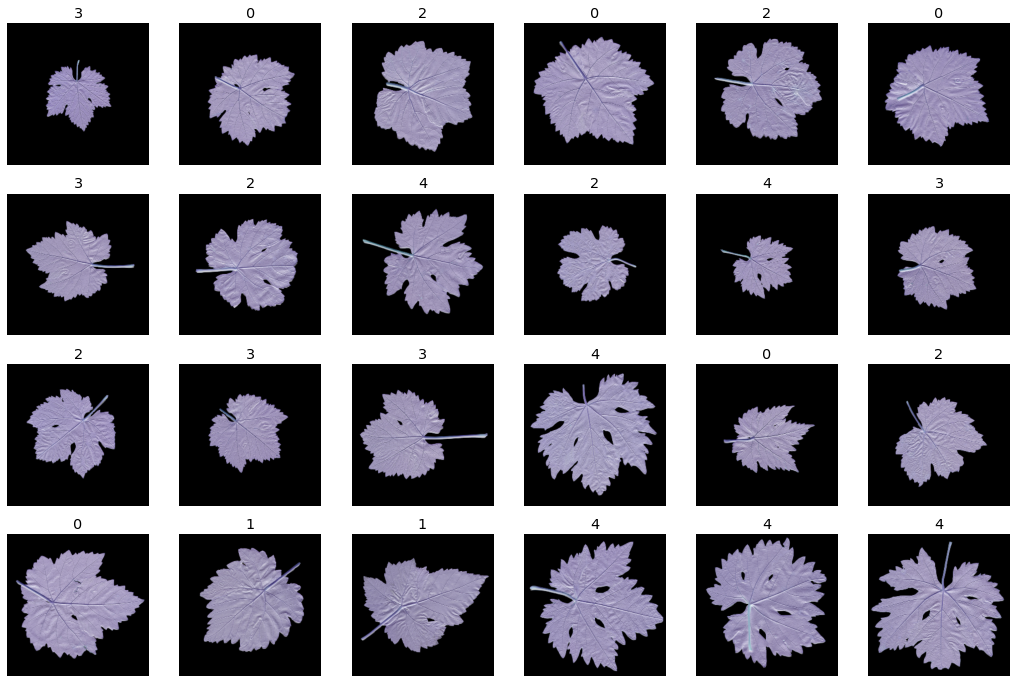

In [ ]:
plt.figure(figsize=(18, 12))
for images, labels in augmented_train_data.take(1):
    for i in range(24):
        ax = plt.subplot(4, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")


## My own Convolutional neural network Model

### Model Architecture Define

In [ ]:
MyOwnModel = keras.models.Sequential([
    layers.RandomRotation(0.1, fill_mode='constant', fill_value=0, input_shape=image_size + (3,)),
    layers.RandomFlip("horizontal"),
    layers.RandomFlip("vertical"),
    layers.Conv2D(16, (3, 3), activation='relu'), 
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(32, (3, 3), activation='relu'), 
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'), 
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu'), 
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(256, (3, 3), activation='relu'), 
    layers.MaxPooling2D(2,2),
    layers.Conv2D(512, (3, 3), activation='relu'), 
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(5, activation='softmax')
])
MyOwnModel.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_rotation_1 (RandomRo  (None, 256, 256, 3)      0         
 tation)                                                         
                                                                 
 random_flip_2 (RandomFlip)  (None, 256, 256, 3)       0         
                                                                 
 random_flip_3 (RandomFlip)  (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)     

### Model Creation and Training

In [ ]:
MyOwnModel.compile(
    optimizer=keras.optimizers.Adam(2*1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)
epochs = 200
history_myown = MyOwnModel.fit(
    train_data2, epochs=epochs,
    validation_data=validation_data2)
MyOwnModel.save('MyOwnModel.h5')

### Accuracy Curve

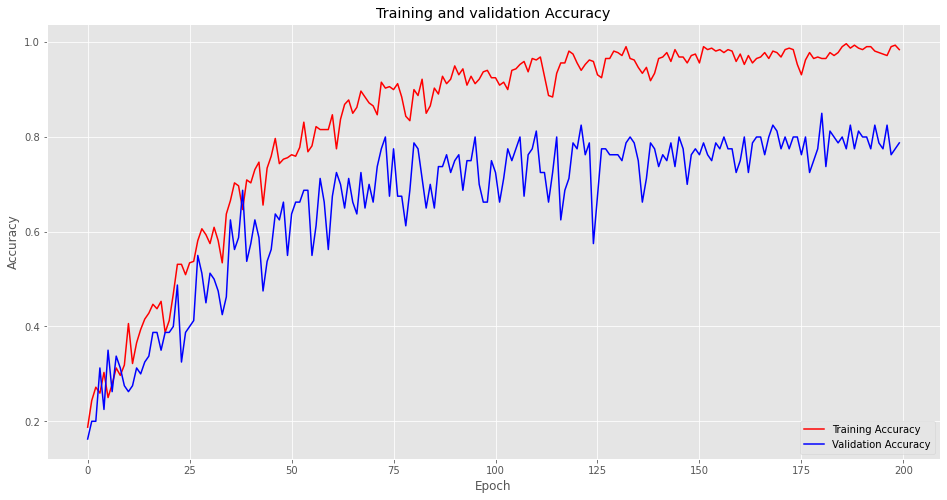

In [ ]:
MyOwnModel_acc=history_myown.history['accuracy']
MyOwnModel_val_acc=history_myown.history['val_accuracy']
MyOwnModel_loss=history_myown.history['loss']
MyOwnModel_val_loss=history_myown.history['val_loss']
epochs=range(len(MyOwnModel_acc))
fig = plt.figure(figsize=(16,8))
plt.plot(epochs, MyOwnModel_acc, 'r', label="Training Accuracy")
plt.plot(epochs, MyOwnModel_val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation Accuracy')
plt.legend(loc='lower right')
plt.show()

### Loss Curve

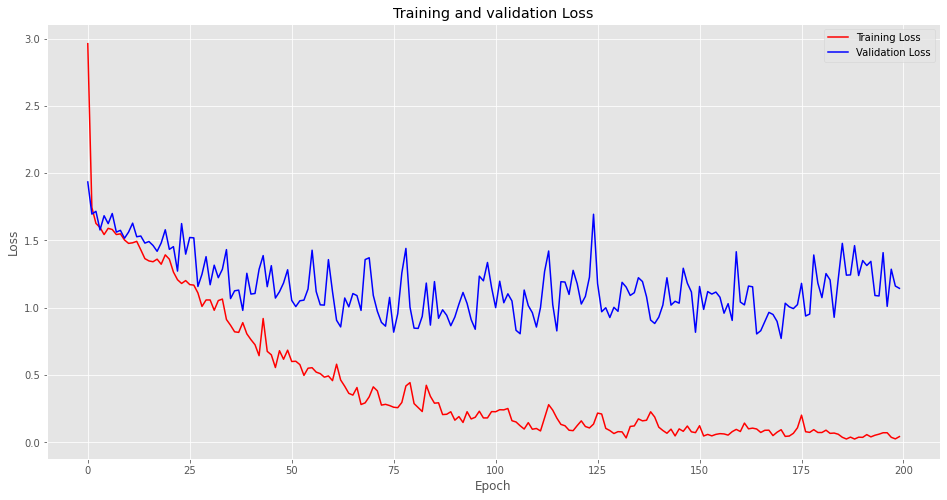

In [ ]:
fig2 = plt.figure(figsize=(16,8))
plt.plot(epochs, MyOwnModel_loss, 'r', label="Training Loss")
plt.plot(epochs, MyOwnModel_val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation Loss')
plt.show()

### Model Performance Evaluation on Test Data 

In [ ]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
result = MyOwnModel.predict(test_data2)
y_test = np.concatenate([y for x, y in test_data2], axis=0)
MyOwnModel_y_predict = np.array([i.argmax() for i in result])

MyOwnModel_cm = confusion_matrix(y_test, MyOwnModel_y_predict)
MyOwnModel_ac = accuracy_score(y_test,MyOwnModel_y_predict)

print("confusion matrix on test data :\n",MyOwnModel_cm)
print("accuracy score on test data:\n",MyOwnModel_ac)

print(classification_report(y_test, MyOwnModel_y_predict))

confusion matrix on test data :
 [[14  3  0  3  0]
 [ 2 15  0  2  1]
 [ 1  1 14  3  1]
 [ 0  2  0 17  1]
 [ 0  0  0  0 20]]
accuracy score on test data:
 0.8
              precision    recall  f1-score   support

           0       0.82      0.70      0.76        20
           1       0.71      0.75      0.73        20
           2       1.00      0.70      0.82        20
           3       0.68      0.85      0.76        20
           4       0.87      1.00      0.93        20

    accuracy                           0.80       100
   macro avg       0.82      0.80      0.80       100
weighted avg       0.82      0.80      0.80       100

